In [1]:
import torch
import os
import pandas as pd
import numpy as np
import clip
from PIL import Image
from tqdm import tqdm
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load datasets
all_details_df = pd.read_csv('amazon_dataset/clothing_shoes_jewellery/all_products.csv')
co_purchase_df = pd.read_csv('kcore5new_brand.csv')

In [3]:
all_details_df.set_index('asin', inplace=True)

In [4]:


# Assuming your DataFrames are loaded as co_purchase and all_products_df
unique_asins = co_purchase_df['asin'].unique()

# Directory
image_folder_path = '/home/arnuv/amazon_dataset/clothing_shoes_jewellery/images/'

# CLIP Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)



In [5]:
# Extracting Titles and Image URLs
titles = []
images = []
brands = []
for asin in tqdm(unique_asins):
    product = all_details_df.loc[asin]
    if not product.empty:
        brands.append(product['brand'])
        titles.append(product['title'])
        image_url = product['imUrl']
        image_name = image_url.split('/')[-1]
        images.append(os.path.join(image_folder_path, image_name))


100%|██████████| 34864/34864 [00:02<00:00, 16074.97it/s]


In [ ]:
processed_images = []
for i, img in enumerate(tqdm(images, desc="Processing Images")):
    processed_img = preprocess(Image.open(img)).unsqueeze(0)
    processed_images.append(processed_img)

raw_images = [Image.open(img) for img in tqdm(images)]


In [6]:

# Processing Text for CLIP
text_tokens = clip.tokenize(titles, truncate = True)

# Processing Text for CLIP
brand_tokens = clip.tokenize(brands, truncate = True)



In [7]:
class ImageDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        return self.image_paths[idx]


class TextDataset(Dataset):
    def __init__(self, text_tokens):
        self.text_tokens = text_tokens

    def __len__(self):
        return len(self.text_tokens)

    def __getitem__(self, idx):
        return self.text_tokens[idx]


In [8]:
image_dataset = ImageDataset(images)
text_dataset = TextDataset(text_tokens)
brand_dataset = TextDataset(brand_tokens)

# Create DataLoaders
image_loader = DataLoader(image_dataset, batch_size=32, shuffle=False)
text_loader = DataLoader(text_dataset, batch_size=32, shuffle=False)
brand_loader = DataLoader(brand_dataset, batch_size=32, shuffle=False)

In [9]:
def process_images(data_loader, preprocess):
    all_embeddings = []
    for image_paths in tqdm(data_loader, desc="Processing Images"):
        with torch.no_grad():
            images = [preprocess(Image.open(img_path)).unsqueeze(0).to(device) for img_path in image_paths]
            embeddings = model.encode_image(torch.cat(images))
            all_embeddings.append(embeddings)
    return torch.cat(all_embeddings)


def process_text(data_loader):
    all_embeddings = []
    for text in tqdm(data_loader, desc="Processing Text"):
        with torch.no_grad():
            embeddings = model.encode_text(text.to(device))
            all_embeddings.append(embeddings)
    return torch.cat(all_embeddings)


In [10]:
# Generate Embeddings
image_embeddings = process_images(image_loader, preprocess)
image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)


Processing Images: 100%|██████████| 1090/1090 [02:32<00:00,  7.15it/s]


In [11]:
# Normalize the embeddings
text_embeddings = process_text(text_loader)
text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)


Processing Text: 100%|██████████| 1090/1090 [00:08<00:00, 121.30it/s]


In [12]:
# Normalize the embeddings
brand_embeddings = process_text(brand_loader)
brand_embeddings /= brand_embeddings.norm(dim=-1, keepdim=True)


Processing Text: 100%|██████████| 1090/1090 [00:08<00:00, 122.54it/s]


In [13]:
# Saving Embeddings
np.save('text_embeddings_k_5.npy_brand', text_embeddings.cpu().numpy())

In [14]:
# Saving Embeddings
np.save('brand_embeddings_k_5_brand.npy', brand_embeddings.cpu().numpy())

In [15]:

np.save('image_embeddings.npy_k_5_brand', image_embeddings.cpu().numpy())


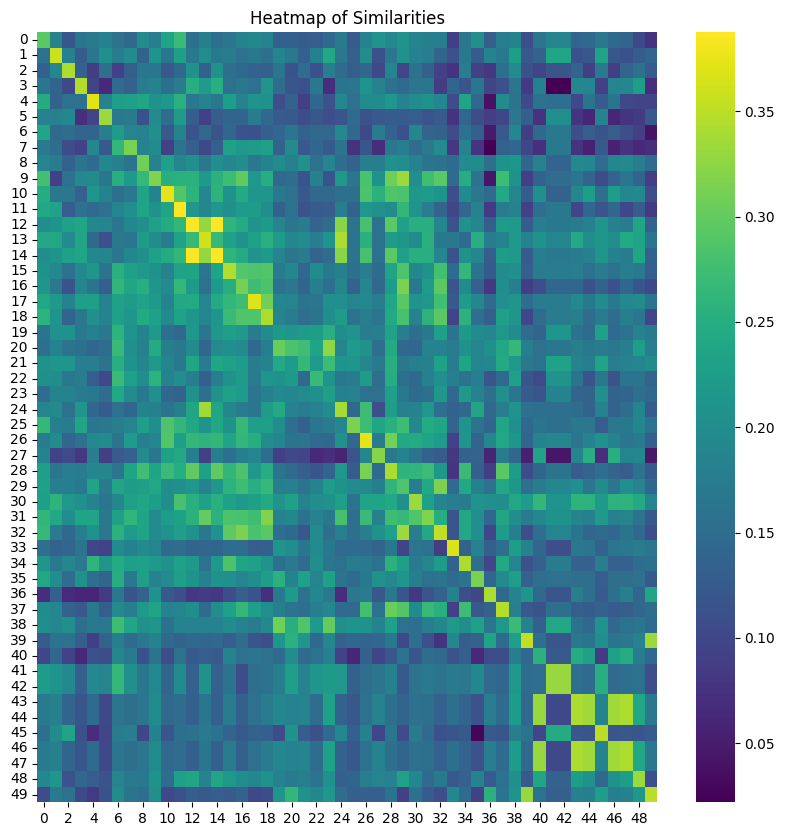

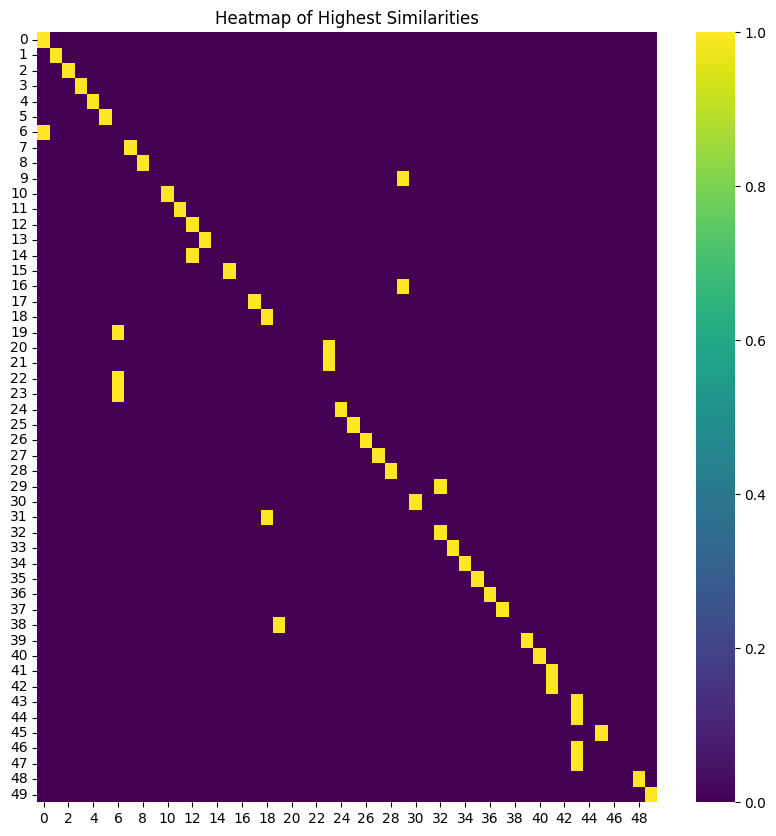

In [50]:
#Validating CLIP Embeddings

similarities = text_embeddings[0:50].cpu().numpy() @ image_embeddings[0:50].cpu().numpy().T

plt.figure(figsize=(10, 10))
sns.heatmap(similarities, cmap='viridis')
plt.title('Heatmap of Similarities')
plt.show()

highest_similarity_indices = np.argmax(similarities, axis=1)
binary_similarities = np.zeros_like(similarities)
binary_similarities[np.arange(similarities.shape[0]), highest_similarity_indices] = 1

plt.figure(figsize=(10, 10))
sns.heatmap(binary_similarities, cmap='viridis')
plt.title('Heatmap of Highest Similarities')
plt.show()





